In [1]:
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, TimeDistributed, MaxPooling1D, Conv1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle
from scipy.stats import zscore

2025-06-25 17:21:07.094011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750872067.364439      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750872067.436437      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load Train Data
with open("/kaggle/input/data-prep-2/train_data.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

# Load Val Data
with open("/kaggle/input/data-prep-2/val_data.pkl", "rb") as f:
    X_val, y_val = pickle.load(f)

# Transpose to (samples, timesteps, features)
X_train = X_train.transpose(0, 2, 1)
X_val = X_val.transpose(0, 2, 1)

In [3]:
#Flatten for scaler
N, T, F = X_train.shape
X_train_2d = X_train.reshape(-1, F)
X_val_2d = X_val.reshape(-1, F)

#Remove subset of outliers by clipping at percentiles (e.g., 1st and 99th)
lower_percentile = 5
upper_percentile = 95

lower_bounds = np.percentile(X_train_2d, lower_percentile, axis=0)
upper_bounds = np.percentile(X_train_2d, upper_percentile, axis=0)

#Clip train and val features to these bounds to remove extreme outliers
X_train_2d_clipped = np.clip(X_train_2d, lower_bounds, upper_bounds)
X_val_2d_clipped = np.clip(X_val_2d, lower_bounds, upper_bounds)

#Fit scaler on clipped train data
scaler = RobustScaler()
scaler.fit(X_train_2d_clipped)

#Transform clipped train and val data
X_train = scaler.transform(X_train_2d_clipped).reshape(N, T, F)
X_val = scaler.transform(X_val_2d_clipped).reshape(X_val.shape)

In [4]:
# Create label map and convert to integer labels
classes = sorted(set(y_train))
label_map = {label: idx for idx, label in enumerate(classes)}

# Integer encode (for sparse categorical crossentropy)
y_train_encoded = np.array([label_map[l] for l in y_train])
y_val_encoded   = np.array([label_map[l] for l in y_val])

In [5]:
num_features = X_train.shape[2]
time_steps = X_train.shape[1]

In [6]:
# Flatten Train
num_train, time_steps, num_features = X_train.shape
X_train_flat = X_train.reshape(num_train, time_steps * num_features)
feature_names = [f"t{t}_f{f}" for t in range(time_steps) for f in range(num_features)]

df_X_train = pd.DataFrame(X_train_flat, columns=feature_names)
df_y_train = pd.DataFrame(y_train_encoded, columns=["label"])

# Flatten Val
num_val = X_val.shape[0]
X_val_flat = X_val.reshape(num_val, time_steps * num_features)

df_X_val = pd.DataFrame(X_val_flat, columns=feature_names)
df_y_val = pd.DataFrame(y_val_encoded, columns=["label"])

In [7]:
def evaluate_model(model, X_val, y_val):
    y_pred = np.argmax(model.predict(X_val), axis=1)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')
    print("Accuracy:", acc)
    print("F1 Score (macro):", f1)
    print("\nClassification Report:\n", classification_report(y_val, y_pred))
    return acc, f1

In [51]:
def plot_conf_matrix(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes) 
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()


In [9]:
# ==== Default Hyperparameters ====
INPUT_SHAPE = (time_steps, num_features)
NUM_CLASSES = 10
LSTM_UNITS = 128
DENSE_UNITS = 128
DROPOUT_RATE = 0.2
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.005
PROJECTION_DIM = 32
LOSS_FUNCTION = "sparse_categorical_crossentropy"
OPTIMIZER = "adam"

In [10]:
X_train = np.array(X_train).astype('float32')
y_train = np.array(y_train_encoded).astype('int64')

X_val = np.array(X_val).astype('float32')
y_val = np.array(y_val_encoded).astype('int64')


In [11]:
print(X_train.shape, X_train.dtype, type(X_train))  # should be (samples, timesteps, features), float32, <class 'numpy.ndarray'>
print(y_train.shape, y_train.dtype, type(y_train))  # should be (samples,), int64, <class 'numpy.ndarray'>


(21740, 180, 54) float32 <class 'numpy.ndarray'>
(21740,) int64 <class 'numpy.ndarray'>


In [12]:
def build_and_train_LSTM_model(model_name,input_shape=INPUT_SHAPE,lstm_units=LSTM_UNITS,dense_units=DENSE_UNITS,num_classes=NUM_CLASSES,epochs=EPOCHS ,dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE,loss_function=LOSS_FUNCTION, optimizer=OPTIMIZER,X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,projection_dim=PROJECTION_DIM):
    
    model = Sequential([
        TimeDistributed(Dense(projection_dim, activation='linear'), input_shape=input_shape),
        LSTM(lstm_units, return_sequences=True),
        LSTM(lstm_units, return_sequences=False),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    
    model.summary()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss_function,
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
        ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True),  
        ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=2)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    

    # Save Final Model
    #model.save(f'{model_name}.h5')
    
    
    plt.plot(history.history['loss'], label='Train Loss')    
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve for {}'.format(model_name))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
    acc, f1 = evaluate_model(model, X_val, y_val)
    return model, history, acc, f1


    

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1750872126.700004      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 180, 32)             │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 180, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,578 (912.41 KB)

 Trainable params: 233,578 (912.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


I0000 00:00:1750872142.021476      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


340/340 ━━━━━━━━━━━━━━━━━━━━ 29s 48ms/step - accuracy: 0.3974 - loss: 1.6552 - val_accuracy: 0.4007 - val_loss: 1.7617 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5505 - loss: 1.2511 - val_accuracy: 0.4713 - val_loss: 1.6968 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6407 - loss: 1.0599 - val_accuracy: 0.4939 - val_loss: 1.6991 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7174 - loss: 0.8411 - val_accuracy: 0.5059 - val_loss: 1.6157 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7405 - loss: 0.7836 - val_accuracy: 0.5423 - val_loss: 1.6242 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7629 - loss: 0.6922 - val_accuracy: 0.5068 - val_loss: 1.7613 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.8307 - loss: 

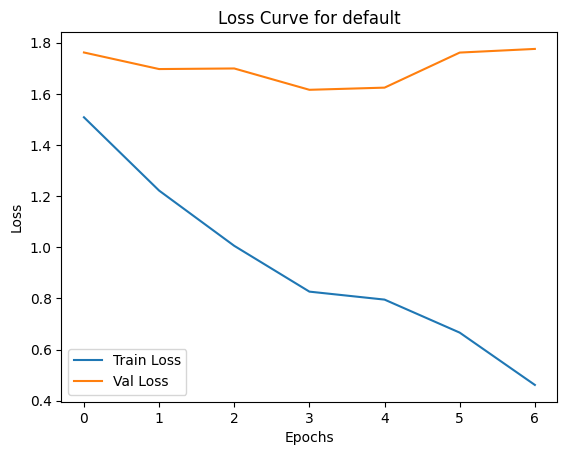

206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
Accuracy: 0.5059306569343066
F1 Score (macro): 0.519413153535634

Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.38      0.37       800
           1       0.66      0.62      0.64       232
           2       0.54      0.60      0.57       800
           3       0.55      0.76      0.64       800
           4       0.66      0.35      0.46       800
           5       0.26      0.24      0.25       776
           6       0.83      0.50      0.62       324
           7       0.47      0.49      0.48       616
           8       0.59      0.68      0.63       628
           9       0.54      0.55      0.55       800

    accuracy                           0.51      6576
   macro avg       0.54      0.52      0.52      6576
weighted avg       0.52      0.51      0.50      6576



In [13]:
default = build_and_train_LSTM_model(model_name="default")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_1 (TimeDistributed) │ (None, 180, 32)             │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 180, 256)            │         295,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 857,194 (3.27 MB)

 Trainable params: 857,194 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 32s 63ms/step - accuracy: 0.3290 - loss: 1.8386 - val_accuracy: 0.3723 - val_loss: 1.7697 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.4724 - loss: 1.4545 - val_accuracy: 0.4071 - val_loss: 1.7325 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.5706 - loss: 1.2093 - val_accuracy: 0.4597 - val_loss: 1.6821 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.6548 - loss: 0.9944 - val_accuracy: 0.5328 - val_loss: 1.5256 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.7238 - loss: 0.8037 - val_accuracy: 0.5123 - val_loss: 1.6550 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.7478 - loss: 0.7209 - val_accuracy: 0.5252 - val_loss: 1.7051 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.8

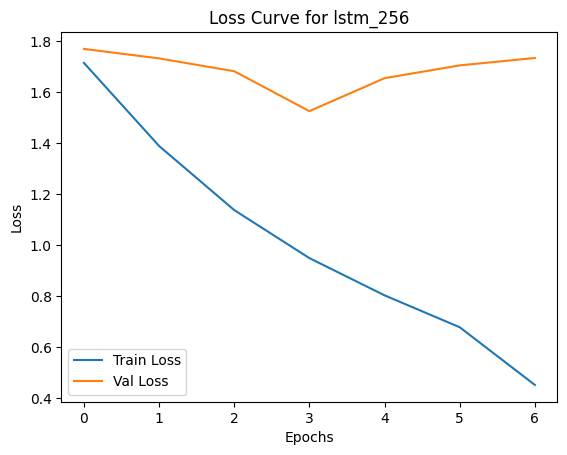

206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
Accuracy: 0.5328467153284672
F1 Score (macro): 0.5415753782037901

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.16      0.23       800
           1       0.72      0.50      0.59       232
           2       0.59      0.56      0.57       800
           3       0.70      0.67      0.68       800
           4       0.55      0.43      0.49       800
           5       0.45      0.49      0.47       776
           6       0.82      0.69      0.75       324
           7       0.39      0.59      0.47       616
           8       0.55      0.78      0.65       628
           9       0.47      0.60      0.53       800

    accuracy                           0.53      6576
   macro avg       0.56      0.55      0.54      6576
weighted avg       0.54      0.53      0.52      6576



In [14]:
lstm_256 =build_and_train_LSTM_model(model_name="lstm_256", lstm_units=256)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_2 (TimeDistributed) │ (None, 180, 32)             │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 180, 64)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,226 (270.41 KB)

 Trainable params: 69,226 (270.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.3886 - loss: 1.6554 - val_accuracy: 0.3788 - val_loss: 1.7903 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5445 - loss: 1.2520 - val_accuracy: 0.4357 - val_loss: 1.6833 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.6406 - loss: 0.9843 - val_accuracy: 0.4370 - val_loss: 1.8582 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.6711 - loss: 0.9092 - val_accuracy: 0.4627 - val_loss: 1.6626 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.6842 - loss: 0.8802 - val_accuracy: 0.4585 - val_loss: 1.6859 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.6900 - loss: 0.8861 - val_accuracy: 0.5552 - val_loss: 1.6302 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.7

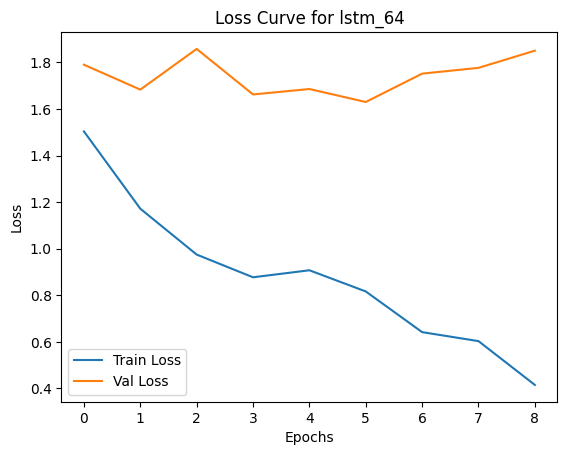

206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
Accuracy: 0.5552007299270073
F1 Score (macro): 0.5460497845556975

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.56      0.54       800
           1       0.41      0.44      0.43       232
           2       0.58      0.54      0.56       800
           3       0.62      0.69      0.65       800
           4       0.65      0.39      0.49       800
           5       0.67      0.49      0.57       776
           6       0.58      0.54      0.56       324
           7       0.43      0.51      0.47       616
           8       0.64      0.73      0.68       628
           9       0.45      0.59      0.51       800

    accuracy                           0.56      6576
   macro avg       0.56      0.55      0.55      6576
weighted avg       0.57      0.56      0.55      6576



In [15]:
lstm_64 = build_and_train_LSTM_model(model_name="lstm_64", lstm_units=64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_3 (TimeDistributed) │ (None, 180, 32)             │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 180, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,578 (912.41 KB)

 Trainable params: 233,578 (912.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.3889 - loss: 1.6924 - val_accuracy: 0.3756 - val_loss: 1.8227 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5250 - loss: 1.3159 - val_accuracy: 0.4310 - val_loss: 1.7788 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6215 - loss: 1.0837 - val_accuracy: 0.5055 - val_loss: 1.7050 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6687 - loss: 0.9840 - val_accuracy: 0.5058 - val_loss: 1.7025 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7400 - loss: 0.7807 - val_accuracy: 0.5049 - val_loss: 1.8141 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7489 - loss: 0.7644 - val_accuracy: 0.5345 - val_loss: 1.8003 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.8

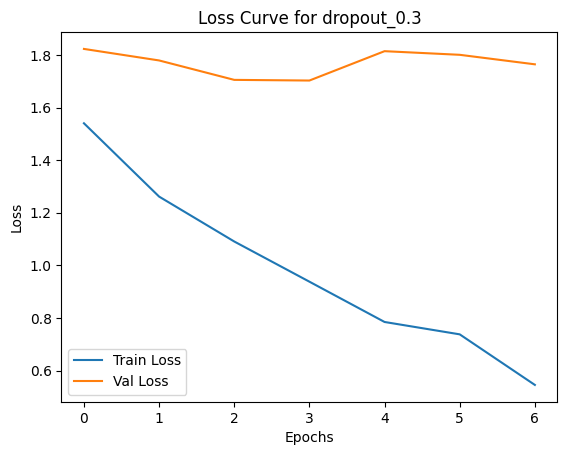

206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
Accuracy: 0.5057785888077859
F1 Score (macro): 0.5019024906233923

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.43      0.43       800
           1       0.47      0.31      0.38       232
           2       0.48      0.65      0.55       800
           3       0.66      0.75      0.70       800
           4       0.52      0.41      0.46       800
           5       0.46      0.31      0.37       776
           6       0.70      0.66      0.68       324
           7       0.35      0.48      0.41       616
           8       0.64      0.69      0.66       628
           9       0.45      0.35      0.40       800

    accuracy                           0.51      6576
   macro avg       0.51      0.50      0.50      6576
weighted avg       0.51      0.51      0.50      6576



In [16]:
dropout_03 =build_and_train_LSTM_model(model_name="dropout_0.3", dropout_rate=0.3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_4 (TimeDistributed) │ (None, 180, 32)             │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 180, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,578 (912.41 KB)

 Trainable params: 233,578 (912.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.3788 - loss: 1.6937 - val_accuracy: 0.4040 - val_loss: 1.7329 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5547 - loss: 1.2458 - val_accuracy: 0.4348 - val_loss: 1.8020 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6646 - loss: 0.9836 - val_accuracy: 0.4932 - val_loss: 1.6919 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7188 - loss: 0.8306 - val_accuracy: 0.4851 - val_loss: 1.6545 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7357 - loss: 0.7945 - val_accuracy: 0.5245 - val_loss: 1.6558 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7472 - loss: 0.7607 - val_accuracy: 0.5184 - val_loss: 1.7218 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.8

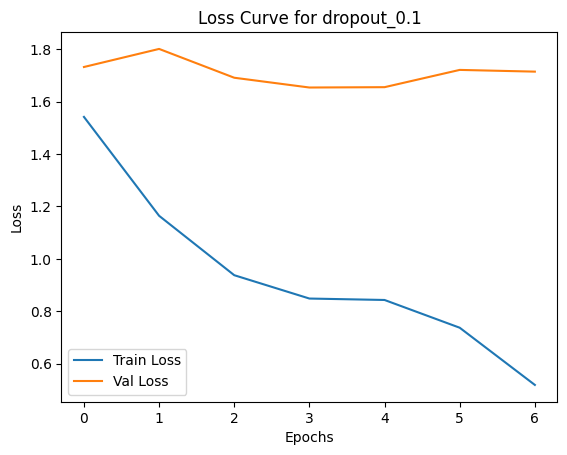

206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Accuracy: 0.48509732360097324
F1 Score (macro): 0.49805767024404546

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.37      0.40       800
           1       0.56      0.73      0.63       232
           2       0.41      0.61      0.49       800
           3       0.74      0.59      0.66       800
           4       0.45      0.26      0.33       800
           5       0.32      0.21      0.25       776
           6       0.67      0.53      0.59       324
           7       0.34      0.66      0.45       616
           8       0.62      0.74      0.67       628
           9       0.60      0.44      0.51       800

    accuracy                           0.49      6576
   macro avg       0.51      0.51      0.50      6576
weighted avg       0.50      0.49      0.48      6576



In [17]:
dropout_01 = build_and_train_LSTM_model(model_name="dropout_0.1", dropout_rate=0.1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_5 (TimeDistributed) │ (None, 180, 32)             │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 180, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,578 (912.41 KB)

 Trainable params: 233,578 (912.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 26s 46ms/step - accuracy: 0.3714 - loss: 1.7385 - val_accuracy: 0.4126 - val_loss: 1.6571 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5505 - loss: 1.2818 - val_accuracy: 0.4805 - val_loss: 1.5961 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6581 - loss: 1.0203 - val_accuracy: 0.5362 - val_loss: 1.5250 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7176 - loss: 0.8480 - val_accuracy: 0.5461 - val_loss: 1.6425 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7452 - loss: 0.7750 - val_accuracy: 0.5379 - val_loss: 1.7471 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7856 - loss: 0.6277 - val_accuracy: 0.5464 - val_loss: 1.7422 - learning_rate: 5.0000e-04


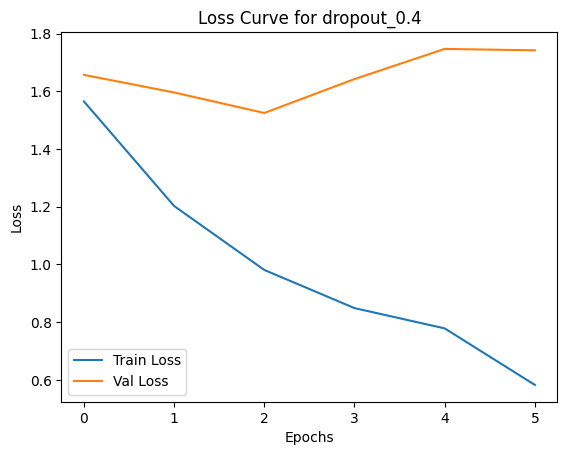

206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step
Accuracy: 0.5361922141119222
F1 Score (macro): 0.544133233458011

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.43      0.47       800
           1       0.52      0.61      0.56       232
           2       0.58      0.48      0.52       800
           3       0.65      0.57      0.61       800
           4       0.72      0.46      0.56       800
           5       0.48      0.36      0.41       776
           6       0.70      0.56      0.62       324
           7       0.40      0.74      0.52       616
           8       0.62      0.72      0.67       628
           9       0.45      0.58      0.50       800

    accuracy                           0.54      6576
   macro avg       0.56      0.55      0.54      6576
weighted avg       0.56      0.54      0.54      6576



In [18]:
dropout_04 = build_and_train_LSTM_model(model_name="dropout_0.4", dropout_rate=0.4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_6 (TimeDistributed) │ (None, 180, 32)             │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 180, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,578 (912.41 KB)

 Trainable params: 233,578 (912.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.1457 - loss: 2.2869 - val_accuracy: 0.0937 - val_loss: 2.2624 - learning_rate: 0.0500
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.1133 - loss: 2.2672 - val_accuracy: 0.1217 - val_loss: 2.2586 - learning_rate: 0.0500
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.1189 - loss: 2.2645 - val_accuracy: 0.0937 - val_loss: 2.2607 - learning_rate: 0.0500
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.1222 - loss: 2.2634 - val_accuracy: 0.0937 - val_loss: 2.2686 - learning_rate: 0.0500
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.1229 - loss: 2.2659 - val_accuracy: 0.0937 - val_loss: 2.2582 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.1251 - loss: 2.2622 - val_accuracy: 0.0937 - val_loss: 2.2599 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.1

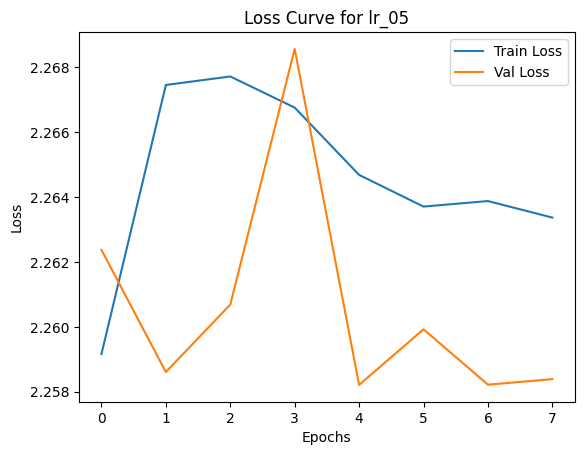

206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Accuracy: 0.09367396593673966
F1 Score (macro): 0.017130144605116797

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       800
           1       0.00      0.00      0.00       232
           2       0.00      0.00      0.00       800
           3       0.00      0.00      0.00       800
           4       0.00      0.00      0.00       800
           5       0.00      0.00      0.00       776
           6       0.00      0.00      0.00       324
           7       0.09      1.00      0.17       616
           8       0.00      0.00      0.00       628
           9       0.00      0.00      0.00       800

    accuracy                           0.09      6576
   macro avg       0.01      0.10      0.02      6576
weighted avg       0.01      0.09      0.02      6576



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
lr_05 =build_and_train_LSTM_model(model_name="lr_05", learning_rate=0.05)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_7 (TimeDistributed) │ (None, 180, 32)             │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 180, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,578 (912.41 KB)

 Trainable params: 233,578 (912.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.4430 - loss: 1.5743 - val_accuracy: 0.4316 - val_loss: 1.6601 - learning_rate: 0.0010
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6400 - loss: 1.0341 - val_accuracy: 0.4238 - val_loss: 1.8283 - learning_rate: 0.0010
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6384 - loss: 1.0246 - val_accuracy: 0.4431 - val_loss: 1.8167 - learning_rate: 0.0010
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7165 - loss: 0.8211 - val_accuracy: 0.4860 - val_loss: 1.6915 - learning_rate: 1.0000e-04


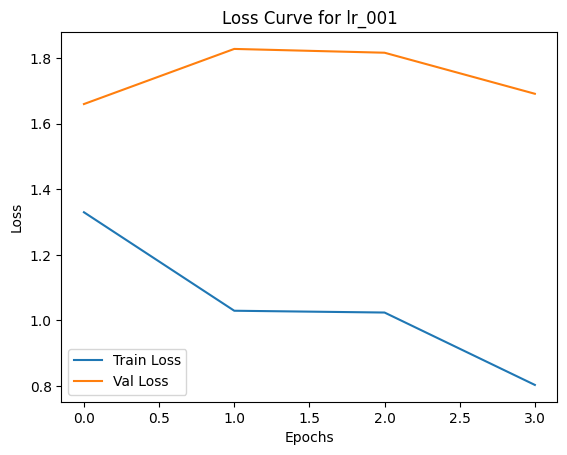

206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step
Accuracy: 0.43156934306569344
F1 Score (macro): 0.40545318775088585

Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.35      0.33       800
           1       0.12      0.08      0.10       232
           2       0.46      0.48      0.47       800
           3       0.63      0.35      0.45       800
           4       0.62      0.35      0.44       800
           5       0.37      0.19      0.25       776
           6       0.29      0.85      0.44       324
           7       0.49      0.44      0.46       616
           8       0.58      0.72      0.64       628
           9       0.40      0.56      0.46       800

    accuracy                           0.43      6576
   macro avg       0.43      0.44      0.41      6576
weighted avg       0.46      0.43      0.42      6576



In [20]:
lr_001 = build_and_train_LSTM_model(model_name="lr_001", learning_rate=0.001)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_8 (TimeDistributed) │ (None, 180, 32)             │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 180, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,578 (912.41 KB)

 Trainable params: 233,578 (912.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.3064 - loss: 1.8557 - val_accuracy: 0.3397 - val_loss: 1.7410 - learning_rate: 0.0100
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.4489 - loss: 1.4649 - val_accuracy: 0.4223 - val_loss: 1.6166 - learning_rate: 0.0100
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5545 - loss: 1.2275 - val_accuracy: 0.4568 - val_loss: 1.5919 - learning_rate: 0.0100
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6291 - loss: 1.0667 - val_accuracy: 0.5076 - val_loss: 1.5293 - learning_rate: 0.0100
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6578 - loss: 1.0025 - val_accuracy: 0.5138 - val_loss: 1.5648 - learning_rate: 0.0100
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6952 - loss: 0.8795 - val_accuracy: 0.5143 - val_loss: 1.5242 - learning_rate: 0.0100
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7

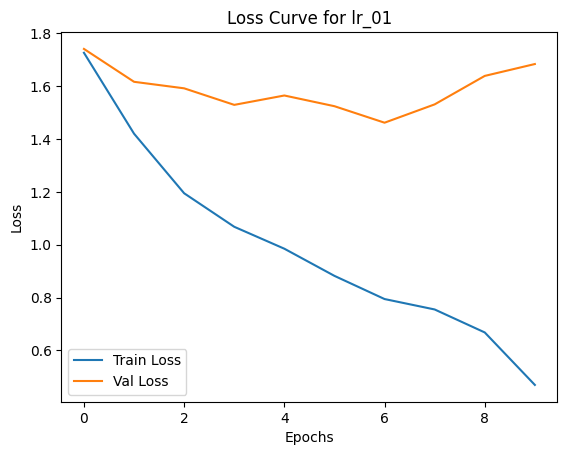

206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step
Accuracy: 0.573905109489051
F1 Score (macro): 0.5812428667310983

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.46      0.53       800
           1       0.54      0.66      0.59       232
           2       0.65      0.39      0.49       800
           3       0.67      0.75      0.71       800
           4       0.58      0.49      0.53       800
           5       0.63      0.63      0.63       776
           6       0.80      0.64      0.71       324
           7       0.41      0.47      0.44       616
           8       0.62      0.74      0.67       628
           9       0.43      0.62      0.51       800

    accuracy                           0.57      6576
   macro avg       0.60      0.59      0.58      6576
weighted avg       0.59      0.57      0.57      6576



In [21]:
lr_01 = build_and_train_LSTM_model(model_name="lr_01", learning_rate=0.01)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_9 (TimeDistributed) │ (None, 180, 32)             │           1,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 180, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,578 (912.41 KB)

 Trainable params: 233,578 (912.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
680/680 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.3441 - loss: 1.7804 - val_accuracy: 0.3855 - val_loss: 1.7096 - learning_rate: 0.0050
Epoch 2/100
680/680 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.5416 - loss: 1.2852 - val_accuracy: 0.4360 - val_loss: 1.7319 - learning_rate: 0.0050
Epoch 3/100
680/680 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.6385 - loss: 1.0700 - val_accuracy: 0.4780 - val_loss: 1.6263 - learning_rate: 0.0050
Epoch 4/100
680/680 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.7095 - loss: 0.8825 - val_accuracy: 0.5345 - val_loss: 1.6262 - learning_rate: 0.0050
Epoch 5/100
680/680 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.7129 - loss: 0.8564 - val_accuracy: 0.4979 - val_loss: 1.7979 - learning_rate: 0.0050
Epoch 6/100
680/680 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.7279 - loss: 0.8073 - val_accuracy: 0.4964 - val_loss: 1.7566 - learning_rate: 0.0050
Epoch 7/100
680/680 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - accuracy: 0.8

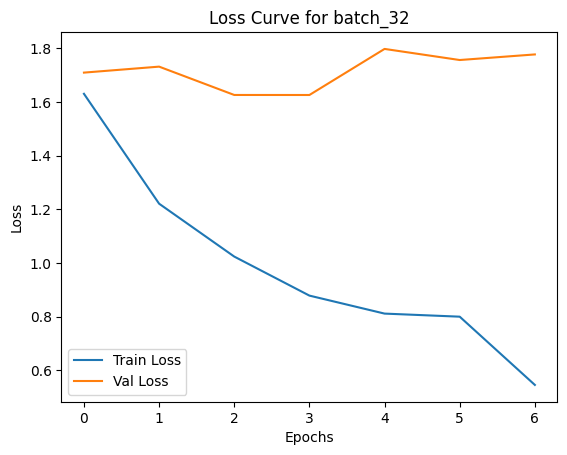

206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step
Accuracy: 0.5345194647201946
F1 Score (macro): 0.5297845111004504

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.47      0.45       800
           1       0.38      0.65      0.48       232
           2       0.48      0.50      0.49       800
           3       0.70      0.71      0.70       800
           4       0.63      0.43      0.51       800
           5       0.48      0.30      0.37       776
           6       0.60      0.45      0.52       324
           7       0.49      0.71      0.58       616
           8       0.67      0.68      0.68       628
           9       0.51      0.55      0.53       800

    accuracy                           0.53      6576
   macro avg       0.54      0.54      0.53      6576
weighted avg       0.54      0.53      0.53      6576



In [22]:
batch_32 = build_and_train_LSTM_model(model_name="batch_32", batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_10                  │ (None, 180, 32)             │           1,760 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 180, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,578 (912.41 KB)

 Trainable params: 233,578 (912.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.4065 - loss: 1.6236 - val_accuracy: 0.4682 - val_loss: 1.6708 - learning_rate: 0.0050
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5703 - loss: 1.2103 - val_accuracy: 0.3745 - val_loss: 1.7973 - learning_rate: 0.0050
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6030 - loss: 1.1343 - val_accuracy: 0.4767 - val_loss: 1.7670 - learning_rate: 0.0050
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.7173 - loss: 0.8279 - val_accuracy: 0.5018 - val_loss: 1.7551 - learning_rate: 5.0000e-04


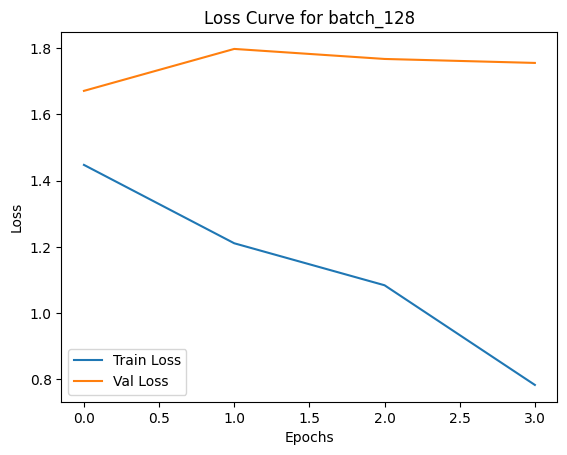

206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step
Accuracy: 0.4682177615571776
F1 Score (macro): 0.42816999022998087

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.30      0.38       800
           1       0.21      0.04      0.07       232
           2       0.52      0.43      0.47       800
           3       0.52      0.57      0.54       800
           4       0.71      0.36      0.48       800
           5       0.52      0.32      0.40       776
           6       0.27      0.57      0.36       324
           7       0.49      0.46      0.48       616
           8       0.51      0.82      0.63       628
           9       0.37      0.64      0.47       800

    accuracy                           0.47      6576
   macro avg       0.46      0.45      0.43      6576
weighted avg       0.50      0.47      0.46      6576



In [23]:
batch_128 = build_and_train_LSTM_model(model_name="batch_128", batch_size=128)

# best models till now were lr_001, lr_01 and dropout_04

In [24]:
best_model = dropout_04

In [25]:
#evaluate_model(best_model, X_test, y_test)

In [26]:
#plot_conf_matrix(best_model, X_test, y_test, class_names)


In [27]:
# ==== New Default Hyperparameters ====
INPUT_SHAPE = (time_steps, num_features)
NUM_CLASSES = 10
LSTM_UNITS = 128
DENSE_UNITS = 128
DROPOUT_RATE = 0.5
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001
PROJECTION_DIM = 32
LOSS_FUNCTION = "sparse_categorical_crossentropy"
OPTIMIZER = "adam"

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_11                  │ (None, 180, 32)             │           1,760 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 180, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,578 (912.41 KB)

 Trainable params: 233,578 (912.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.3971 - loss: 1.6561 - val_accuracy: 0.4377 - val_loss: 1.7258 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.5664 - loss: 1.2147 - val_accuracy: 0.4967 - val_loss: 1.7915 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6535 - loss: 0.9965 - val_accuracy: 0.5093 - val_loss: 1.7226 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.7256 - loss: 0.8091 - val_accuracy: 0.5330 - val_loss: 1.5910 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7526 - loss: 0.7345 - val_accuracy: 0.5398 - val_loss: 1.8059 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.8031 - loss: 0.5914 - val_accuracy: 0.5426 - val_loss: 1.7181 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.8

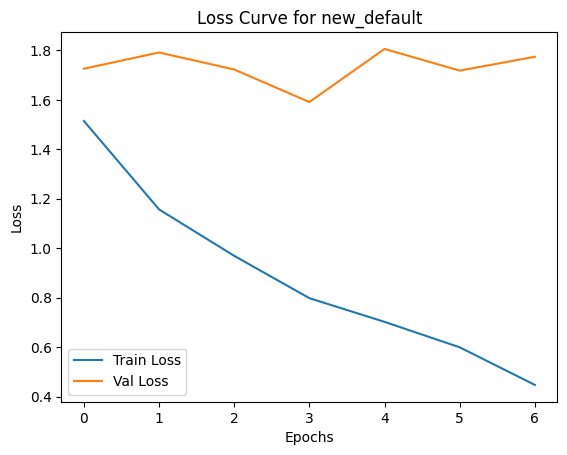

206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step
Accuracy: 0.5329987834549879
F1 Score (macro): 0.5429727628884611

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.45      0.46       800
           1       0.57      0.71      0.64       232
           2       0.56      0.43      0.48       800
           3       0.60      0.70      0.65       800
           4       0.62      0.40      0.49       800
           5       0.62      0.41      0.50       776
           6       0.74      0.51      0.61       324
           7       0.46      0.75      0.57       616
           8       0.58      0.52      0.55       628
           9       0.41      0.60      0.49       800

    accuracy                           0.53      6576
   macro avg       0.57      0.55      0.54      6576
weighted avg       0.55      0.53      0.53      6576



In [28]:
new_default = build_and_train_LSTM_model(model_name="new_default")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_12                  │ (None, 180, 64)             │           3,520 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ (None, 180, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251,722 (983.29 KB)

 Trainable params: 251,722 (983.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.4016 - loss: 1.6657 - val_accuracy: 0.4205 - val_loss: 1.6135 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5439 - loss: 1.2849 - val_accuracy: 0.3619 - val_loss: 1.9287 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6307 - loss: 1.0578 - val_accuracy: 0.4976 - val_loss: 1.6230 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7268 - loss: 0.8155 - val_accuracy: 0.5417 - val_loss: 1.6075 - learning_rate: 5.0000e-04
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7854 - loss: 0.6371 - val_accuracy: 0.5424 - val_loss: 1.6588 - learning_rate: 5.0000e-04
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.8175 - loss: 0.5396 - val_accuracy: 0.5411 - val_loss: 1.7214 - learning_rate: 5.0000e-04
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - a

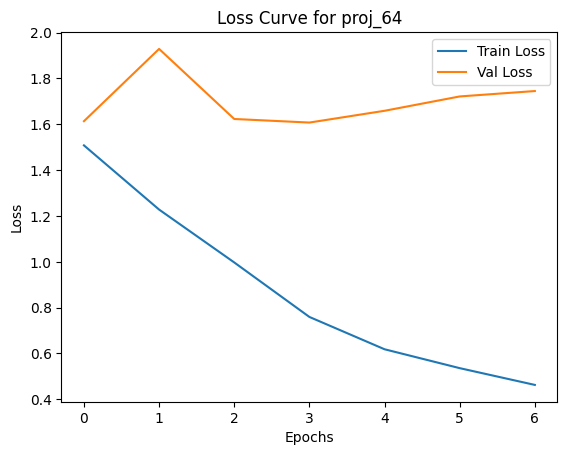

206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Accuracy: 0.5416666666666666
F1 Score (macro): 0.5505370144293138

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.45      0.47       800
           1       0.57      0.54      0.56       232
           2       0.44      0.54      0.48       800
           3       0.67      0.67      0.67       800
           4       0.62      0.39      0.48       800
           5       0.49      0.42      0.45       776
           6       0.62      0.71      0.66       324
           7       0.53      0.65      0.58       616
           8       0.63      0.67      0.65       628
           9       0.48      0.53      0.50       800

    accuracy                           0.54      6576
   macro avg       0.55      0.56      0.55      6576
weighted avg       0.55      0.54      0.54      6576



In [29]:
PROJ_64 = build_and_train_LSTM_model(model_name="proj_64", projection_dim=64)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_13                  │ (None, 180, 16)             │             880 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_26 (LSTM)                       │ (None, 180, 128)            │          74,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 224,506 (876.98 KB)

 Trainable params: 224,506 (876.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 27s 46ms/step - accuracy: 0.3635 - loss: 1.7323 - val_accuracy: 0.3983 - val_loss: 1.7086 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5147 - loss: 1.3462 - val_accuracy: 0.4413 - val_loss: 1.7794 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6228 - loss: 1.0899 - val_accuracy: 0.4708 - val_loss: 1.7215 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.7227 - loss: 0.8202 - val_accuracy: 0.5280 - val_loss: 1.6475 - learning_rate: 5.0000e-04
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.7762 - loss: 0.6541 - val_accuracy: 0.5179 - val_loss: 1.7335 - learning_rate: 5.0000e-04
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.8001 - loss: 0.5773 - val_accuracy: 0.5182 - val_loss: 1.7856 - learning_rate: 5.0000e-04
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - a

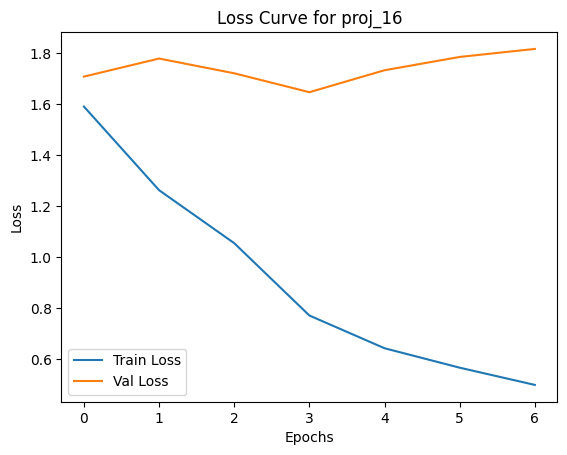

206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
Accuracy: 0.5279805352798054
F1 Score (macro): 0.5396071977846819

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.38      0.38       800
           1       0.60      0.70      0.64       232
           2       0.54      0.62      0.58       800
           3       0.67      0.69      0.68       800
           4       0.72      0.35      0.48       800
           5       0.42      0.28      0.34       776
           6       0.67      0.60      0.63       324
           7       0.47      0.59      0.53       616
           8       0.62      0.68      0.65       628
           9       0.44      0.58      0.50       800

    accuracy                           0.53      6576
   macro avg       0.55      0.55      0.54      6576
weighted avg       0.54      0.53      0.52      6576



In [30]:
PROJ_16 = build_and_train_LSTM_model(model_name="proj_16", projection_dim=16)

# Decreasing Projection Dimensionality Seems to increase the accuracy of the model.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_14                  │ (None, 180, 8)              │             440 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, 180, 128)            │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 219,970 (859.26 KB)

 Trainable params: 219,970 (859.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.3081 - loss: 1.8286 - val_accuracy: 0.3818 - val_loss: 1.8153 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.4464 - loss: 1.4997 - val_accuracy: 0.4098 - val_loss: 1.6925 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5317 - loss: 1.3064 - val_accuracy: 0.5071 - val_loss: 1.6152 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5839 - loss: 1.1997 - val_accuracy: 0.4556 - val_loss: 1.7731 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6147 - loss: 1.0992 - val_accuracy: 0.4711 - val_loss: 1.5838 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6853 - loss: 0.9143 - val_accuracy: 0.5219 - val_loss: 1.6606 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7

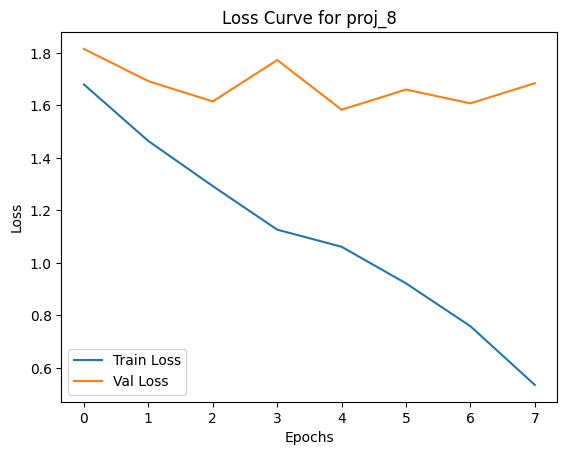

206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Accuracy: 0.47110705596107055
F1 Score (macro): 0.47575448087410976

Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.21      0.25       800
           1       0.53      0.36      0.43       232
           2       0.57      0.43      0.49       800
           3       0.68      0.72      0.70       800
           4       0.50      0.34      0.41       800
           5       0.41      0.49      0.44       776
           6       0.67      0.64      0.65       324
           7       0.34      0.44      0.38       616
           8       0.54      0.69      0.61       628
           9       0.35      0.45      0.40       800

    accuracy                           0.47      6576
   macro avg       0.49      0.48      0.48      6576
weighted avg       0.48      0.47      0.47      6576



In [31]:
PROJ_8 = build_and_train_LSTM_model(model_name="proj_8", projection_dim=8)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_15                  │ (None, 180, 4)              │             220 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ (None, 180, 128)            │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_31 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,702 (850.40 KB)

 Trainable params: 217,702 (850.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.2758 - loss: 1.9620 - val_accuracy: 0.2906 - val_loss: 1.9764 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.3969 - loss: 1.6401 - val_accuracy: 0.4059 - val_loss: 1.7432 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.5231 - loss: 1.2994 - val_accuracy: 0.4615 - val_loss: 1.8063 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5968 - loss: 1.1265 - val_accuracy: 0.4637 - val_loss: 1.6429 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6565 - loss: 0.9833 - val_accuracy: 0.4577 - val_loss: 1.7152 - learning_rate: 0.0050
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7080 - loss: 0.8520 - val_accuracy: 0.4818 - val_loss: 1.8407 - learning_rate: 0.0050
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7

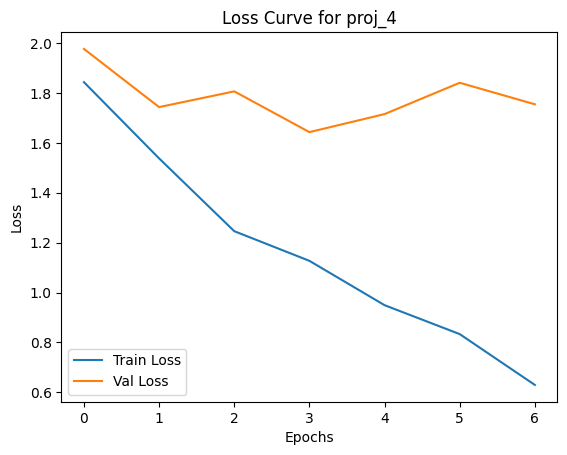

206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Accuracy: 0.4636557177615572
F1 Score (macro): 0.47748374874643035

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.43      0.37       800
           1       0.56      0.44      0.49       232
           2       0.58      0.42      0.48       800
           3       0.74      0.70      0.72       800
           4       0.44      0.31      0.36       800
           5       0.24      0.16      0.20       776
           6       0.71      0.67      0.69       324
           7       0.38      0.51      0.43       616
           8       0.57      0.56      0.56       628
           9       0.39      0.57      0.46       800

    accuracy                           0.46      6576
   macro avg       0.49      0.48      0.48      6576
weighted avg       0.47      0.46      0.46      6576



In [32]:
PROJ_4 = build_and_train_LSTM_model(model_name="proj_4", projection_dim=4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_16                  │ (None, 180, 16)             │             880 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_32 (LSTM)                       │ (None, 180, 64)             │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_33 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,450 (232.23 KB)

 Trainable params: 59,450 (232.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.3300 - loss: 1.8189 - val_accuracy: 0.3639 - val_loss: 1.7525 - learning_rate: 0.0100
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.4588 - loss: 1.4551 - val_accuracy: 0.4323 - val_loss: 1.7225 - learning_rate: 0.0100
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5369 - loss: 1.2806 - val_accuracy: 0.4868 - val_loss: 1.6548 - learning_rate: 0.0100
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.5741 - loss: 1.1973 - val_accuracy: 0.4425 - val_loss: 1.6460 - learning_rate: 0.0100
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.6017 - loss: 1.1406 - val_accuracy: 0.4854 - val_loss: 1.6263 - learning_rate: 0.0100
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.6441 - loss: 1.0439 - val_accuracy: 0.4790 - val_loss: 1.7361 - learning_rate: 0.0100
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.6

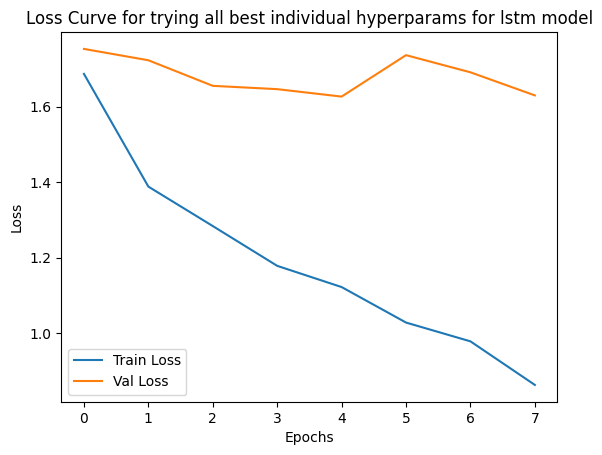

206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step
Accuracy: 0.4854014598540146
F1 Score (macro): 0.4611653749633112

Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.30      0.33       800
           1       0.33      0.09      0.14       232
           2       0.50      0.51      0.51       800
           3       0.73      0.58      0.65       800
           4       0.56      0.34      0.42       800
           5       0.51      0.37      0.43       776
           6       0.45      0.69      0.54       324
           7       0.37      0.68      0.48       616
           8       0.62      0.72      0.67       628
           9       0.40      0.50      0.45       800

    accuracy                           0.49      6576
   macro avg       0.48      0.48      0.46      6576
weighted avg       0.50      0.49      0.48      6576



(<Sequential name=sequential_16, built=True>,
 0.4854014598540146,
 0.4611653749633112)

In [33]:
build_and_train_LSTM_model(model_name="trying all best individual hyperparams for lstm model", lstm_units=64,dense_units=64 ,projection_dim=16,dropout_rate=.4,learning_rate=.01)

# but when we decreased PROJECTION_DIM more, the model was not able to learn anything.

In [34]:
# ==== New Default Hyperparameters ====
INPUT_SHAPE = (time_steps, num_features)
NUM_CLASSES = 10
LSTM_UNITS = 128
DENSE_UNITS = 128
DROPOUT_RATE = 0.5
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001
PROJECTION_DIM = 16
LOSS_FUNCTION = "sparse_categorical_crossentropy"
OPTIMIZER = "adam"

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_17                  │ (None, 180, 32)             │           1,760 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 180, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,578 (912.41 KB)

 Trainable params: 233,578 (912.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.3850 - loss: 1.6758 - val_accuracy: 0.4028 - val_loss: 1.7016 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5213 - loss: 1.3413 - val_accuracy: 0.4693 - val_loss: 1.7258 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.6265 - loss: 1.0994 - val_accuracy: 0.4822 - val_loss: 1.7539 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7429 - loss: 0.7560 - val_accuracy: 0.5196 - val_loss: 1.6861 - learning_rate: 5.0000e-04
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.7985 - loss: 0.5949 - val_accuracy: 0.5257 - val_loss: 1.7431 - learning_rate: 5.0000e-04
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.8287 - loss: 0.5088 - val_accuracy: 0.5366 - val_loss: 1.8068 - learning_rate: 5.0000e-04
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - a

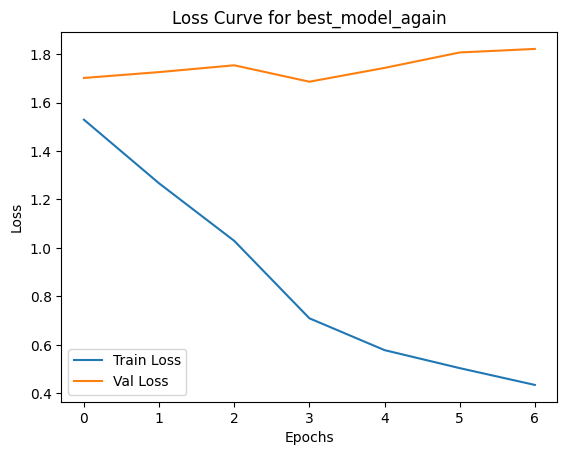

206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Accuracy: 0.5196167883211679
F1 Score (macro): 0.5343119063580085

Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.28      0.30       800
           1       0.63      0.69      0.66       232
           2       0.49      0.54      0.51       800
           3       0.64      0.73      0.68       800
           4       0.64      0.37      0.47       800
           5       0.47      0.33      0.39       776
           6       0.72      0.63      0.67       324
           7       0.44      0.61      0.51       616
           8       0.61      0.64      0.62       628
           9       0.47      0.61      0.53       800

    accuracy                           0.52      6576
   macro avg       0.54      0.54      0.53      6576
weighted avg       0.52      0.52      0.51      6576



In [35]:
best_model_again = build_and_train_LSTM_model(model_name="best_model_again")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_18                  │ (None, 180, 32)             │           1,760 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_36 (LSTM)                       │ (None, 180, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_37 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,578 (912.41 KB)

 Trainable params: 233,578 (912.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 25s 47ms/step - accuracy: 0.3542 - loss: 1.7982 - val_accuracy: 0.3922 - val_loss: 1.7803 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.4761 - loss: 1.4561 - val_accuracy: 0.4547 - val_loss: 1.6299 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.5872 - loss: 1.1877 - val_accuracy: 0.4877 - val_loss: 1.6869 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6509 - loss: 1.0421 - val_accuracy: 0.4564 - val_loss: 1.7796 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.7085 - loss: 0.8929 - val_accuracy: 0.5032 - val_loss: 1.7030 - learning_rate: 5.0000e-04


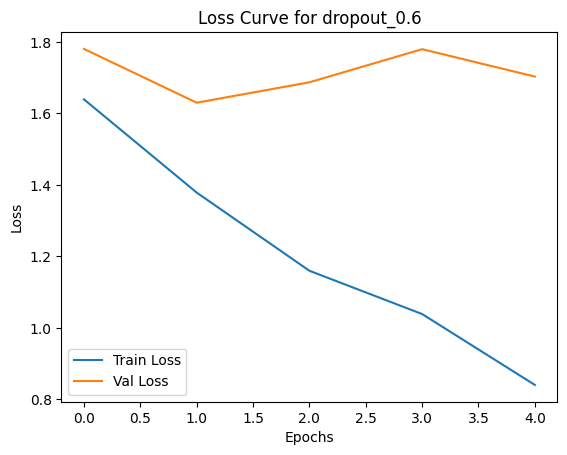

206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
Accuracy: 0.45468369829683697
F1 Score (macro): 0.42226864478284715

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.47      0.43       800
           1       0.26      0.04      0.07       232
           2       0.46      0.40      0.43       800
           3       0.47      0.60      0.53       800
           4       0.67      0.32      0.43       800
           5       0.43      0.35      0.38       776
           6       0.35      0.56      0.43       324
           7       0.36      0.51      0.42       616
           8       0.60      0.66      0.63       628
           9       0.47      0.46      0.47       800

    accuracy                           0.45      6576
   macro avg       0.45      0.44      0.42      6576
weighted avg       0.47      0.45      0.45      6576



In [36]:
dropout_06 = build_and_train_LSTM_model(model_name="dropout_0.6", dropout_rate=0.6)

In [37]:
# ==== 3rd New Default Hyperparameters Keep Dense units double the LSTM units ====


INPUT_SHAPE = (time_steps, num_features)
NUM_CLASSES = 10
LSTM_UNITS = 128
DENSE_UNITS = 256
DROPOUT_RATE = 0.5
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001
PROJECTION_DIM = 64
LOSS_FUNCTION = "sparse_categorical_crossentropy"
OPTIMIZER = "adam"

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_19                  │ (None, 180, 32)             │           1,760 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_38 (LSTM)                       │ (None, 180, 128)            │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_39 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 233,578 (912.41 KB)

 Trainable params: 233,578 (912.41 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.3712 - loss: 1.7281 - val_accuracy: 0.3847 - val_loss: 1.7077 - learning_rate: 0.0050
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.5521 - loss: 1.2455 - val_accuracy: 0.4976 - val_loss: 1.5463 - learning_rate: 0.0050
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.6762 - loss: 0.9329 - val_accuracy: 0.4942 - val_loss: 1.6107 - learning_rate: 0.0050
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.7096 - loss: 0.8737 - val_accuracy: 0.5262 - val_loss: 1.6239 - learning_rate: 0.0050
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.7865 - loss: 0.6144 - val_accuracy: 0.5649 - val_loss: 1.6165 - learning_rate: 5.0000e-04


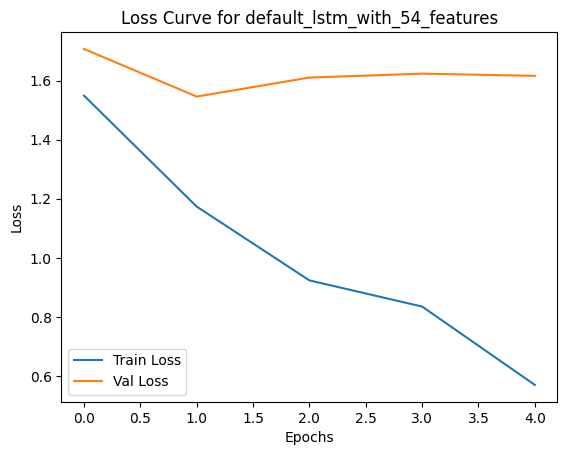

206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Accuracy: 0.4975669099756691
F1 Score (macro): 0.46565498588104803

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.47      0.43       800
           1       0.24      0.14      0.18       232
           2       0.48      0.56      0.52       800
           3       0.56      0.66      0.61       800
           4       0.68      0.32      0.44       800
           5       0.45      0.31      0.37       776
           6       0.55      0.33      0.41       324
           7       0.43      0.64      0.51       616
           8       0.63      0.76      0.69       628
           9       0.48      0.51      0.50       800

    accuracy                           0.50      6576
   macro avg       0.49      0.47      0.47      6576
weighted avg       0.51      0.50      0.49      6576



In [38]:
default_lstm_with_54_features = build_and_train_LSTM_model(model_name="default_lstm_with_54_features")

In [39]:
def build_and_train_LSTM_CNN_model(model_name,input_shape=INPUT_SHAPE,lstm_units=LSTM_UNITS,dense_units=DENSE_UNITS,num_classes=NUM_CLASSES,epochs=EPOCHS ,dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE,loss_function=LOSS_FUNCTION, optimizer=OPTIMIZER,X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,projection_dim=PROJECTION_DIM):
    
    
    
    model = Sequential([
        TimeDistributed(Dense(projection_dim, activation='linear'), input_shape=(input_shape)),
        Conv1D(filters=64, kernel_size=3, activation='relu'),  # (200, 32) → (198, 64)
        MaxPooling1D(pool_size=2),
        LSTM(lstm_units, return_sequences=True),
        LSTM(lstm_units, return_sequences=False),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    
    model.summary()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss_function,
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True),  
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    

    # Save Final Model
    #model.save(f'{model_name}.h5')
    
    
    plt.plot(history.history['loss'], label='Train Loss')    
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve for {}'.format(model_name))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
    acc, f1 = evaluate_model(model, X_val, y_val)
    return model, history, acc, f1


    

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_20                  │ (None, 180, 64)             │           3,520 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 178, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 89, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_40 (LSTM)                       │ (None, 89, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_41 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281,866 (1.08 MB)

 Trainable params: 281,866 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.4422 - loss: 1.5581 - val_accuracy: 0.4729 - val_loss: 1.6214 - learning_rate: 0.0010
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.6700 - loss: 0.9701 - val_accuracy: 0.5148 - val_loss: 1.6300 - learning_rate: 0.0010
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7636 - loss: 0.6916 - val_accuracy: 0.5211 - val_loss: 1.7151 - learning_rate: 0.0010
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8302 - loss: 0.5237 - val_accuracy: 0.5459 - val_loss: 1.6934 - learning_rate: 1.0000e-04


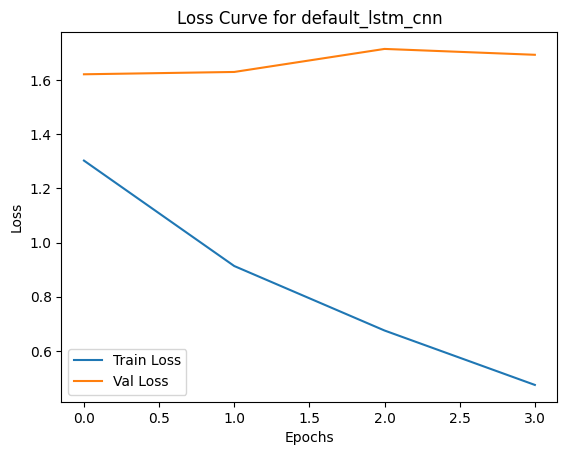

206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Accuracy: 0.47293187347931875
F1 Score (macro): 0.4068861764345975

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.37      0.42       800
           1       0.36      0.08      0.13       232
           2       0.47      0.41      0.43       800
           3       0.42      0.76      0.54       800
           4       0.59      0.45      0.51       800
           5       0.50      0.38      0.43       776
           6       0.06      0.01      0.02       324
           7       0.41      0.45      0.42       616
           8       0.58      0.72      0.64       628
           9       0.44      0.59      0.50       800

    accuracy                           0.47      6576
   macro avg       0.43      0.42      0.41      6576
weighted avg       0.46      0.47      0.45      6576



In [40]:
default_lstm_cnn = build_and_train_LSTM_CNN_model(model_name="default_lstm_cnn")

In [41]:
def build_and_train_Bidirectional_LSTM_model(model_name,input_shape=INPUT_SHAPE,lstm_units=LSTM_UNITS,dense_units=DENSE_UNITS,num_classes=NUM_CLASSES,epochs=EPOCHS ,dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE,loss_function=LOSS_FUNCTION, optimizer=OPTIMIZER,X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,projection_dim=PROJECTION_DIM):
    
    
    model = Sequential([
        TimeDistributed(Dense(projection_dim, activation='linear'), input_shape=input_shape),
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Bidirectional(LSTM(lstm_units, return_sequences=False)),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])
    
    model.summary()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss_function,
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True),  
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    

    # Save Final Model
    #model.save(f'{model_name}.h5')
    
    
    plt.plot(history.history['loss'], label='Train Loss')    
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve for {}'.format(model_name))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
    acc, f1 = evaluate_model(model, X_val, y_val)
    return model, history, acc, f1


    

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_21                  │ (None, 180, 64)             │           3,520 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 180, 256)            │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 663,754 (2.53 MB)

 Trainable params: 663,754 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - accuracy: 0.5505 - loss: 1.3097 - val_accuracy: 0.5532 - val_loss: 1.4981 - learning_rate: 0.0010
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.8181 - loss: 0.5508 - val_accuracy: 0.5789 - val_loss: 1.6720 - learning_rate: 0.0010
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.8708 - loss: 0.3933 - val_accuracy: 0.5357 - val_loss: 1.9693 - learning_rate: 0.0010
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.9260 - loss: 0.2280 - val_accuracy: 0.5658 - val_loss: 1.9184 - learning_rate: 1.0000e-04


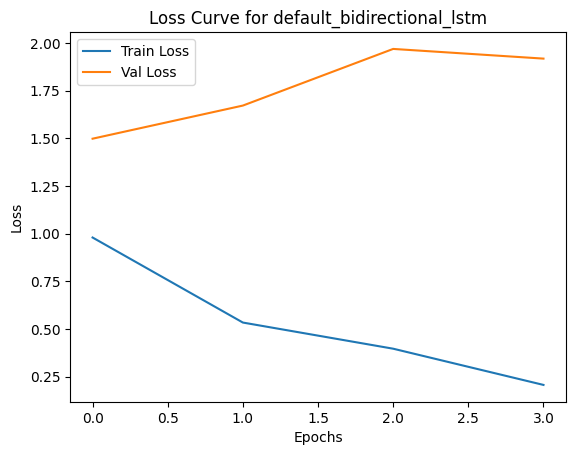

206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step
Accuracy: 0.5532238442822385
F1 Score (macro): 0.5730725541172254

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.41      0.44       800
           1       0.59      0.76      0.67       232
           2       0.46      0.51      0.48       800
           3       0.67      0.72      0.69       800
           4       0.66      0.59      0.62       800
           5       0.37      0.29      0.32       776
           6       0.75      0.82      0.78       324
           7       0.58      0.57      0.57       616
           8       0.64      0.72      0.68       628
           9       0.46      0.49      0.47       800

    accuracy                           0.55      6576
   macro avg       0.56      0.59      0.57      6576
weighted avg       0.55      0.55      0.55      6576



In [42]:
default_bidirectional_lstm = build_and_train_Bidirectional_LSTM_model(model_name="default_bidirectional_lstm")

In [43]:
def build_and_train_Bidirectional_LSTM_CNN_model(model_name,input_shape=INPUT_SHAPE,lstm_units=LSTM_UNITS,dense_units=DENSE_UNITS,num_classes=NUM_CLASSES,epochs=EPOCHS ,dropout_rate=DROPOUT_RATE, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE,loss_function=LOSS_FUNCTION, optimizer=OPTIMIZER,X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val,projection_dim=PROJECTION_DIM):
    
    
    model = Sequential([
    TimeDistributed(Dense(projection_dim, activation='relu'), input_shape=input_shape),  # (200, 3) → (200, 32)
    Conv1D(filters=64, kernel_size=3, activation='relu'),  # (200, 32) → (198, 64)
    MaxPooling1D(pool_size=2),                             # (198, 64) → (99, 64)
    Bidirectional(LSTM(lstm_units, return_sequences=True)),  # → (99, 256)
    Bidirectional(LSTM(lstm_units, return_sequences=False)), # → (256,)
    Dense(dense_units, activation='relu'),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])
    
    model.summary()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss_function,
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(f'{model_name}.keras', monitor='val_loss', save_best_only=True),  
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    

    # Save Final Model
    #model.save(f'{model_name}.h5')
    
    
    plt.plot(history.history['loss'], label='Train Loss')    
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve for {}'.format(model_name))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
    acc, f1 = evaluate_model(model, X_val, y_val)
    return model, history, acc, f1


    

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_22                  │ (None, 180, 64)             │           3,520 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 178, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 89, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 89, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 676,106 (2.58 MB)

 Trainable params: 676,106 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 32s 57ms/step - accuracy: 0.4973 - loss: 1.4211 - val_accuracy: 0.6002 - val_loss: 1.4693 - learning_rate: 0.0010
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8000 - loss: 0.6004 - val_accuracy: 0.5852 - val_loss: 1.6443 - learning_rate: 0.0010
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.8685 - loss: 0.3952 - val_accuracy: 0.6142 - val_loss: 1.5688 - learning_rate: 0.0010
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.9289 - loss: 0.2160 - val_accuracy: 0.6255 - val_loss: 1.6995 - learning_rate: 1.0000e-04


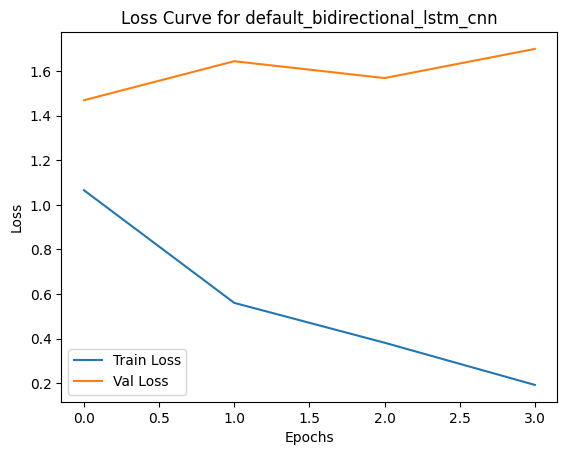

206/206 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step
Accuracy: 0.600212895377129
F1 Score (macro): 0.6184405966531401

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.49      0.58       800
           1       0.63      0.87      0.73       232
           2       0.49      0.57      0.53       800
           3       0.83      0.66      0.74       800
           4       0.71      0.44      0.55       800
           5       0.56      0.37      0.45       776
           6       0.76      0.82      0.79       324
           7       0.56      0.64      0.60       616
           8       0.57      0.84      0.68       628
           9       0.47      0.67      0.55       800

    accuracy                           0.60      6576
   macro avg       0.63      0.64      0.62      6576
weighted avg       0.62      0.60      0.60      6576



In [44]:
default_bidirectional_lstm_cnn = build_and_train_Bidirectional_LSTM_CNN_model(model_name="default_bidirectional_lstm_cnn")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_23                  │ (None, 180, 64)             │           3,520 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 178, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 89, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 89, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,538 (775.54 KB)

 Trainable params: 198,538 (775.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.4299 - loss: 1.6098 - val_accuracy: 0.5525 - val_loss: 1.5580 - learning_rate: 0.0010
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.7600 - loss: 0.7445 - val_accuracy: 0.5652 - val_loss: 1.6006 - learning_rate: 0.0010
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8275 - loss: 0.5427 - val_accuracy: 0.5912 - val_loss: 1.6195 - learning_rate: 0.0010
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.8842 - loss: 0.3705 - val_accuracy: 0.6092 - val_loss: 1.6299 - learning_rate: 1.0000e-04


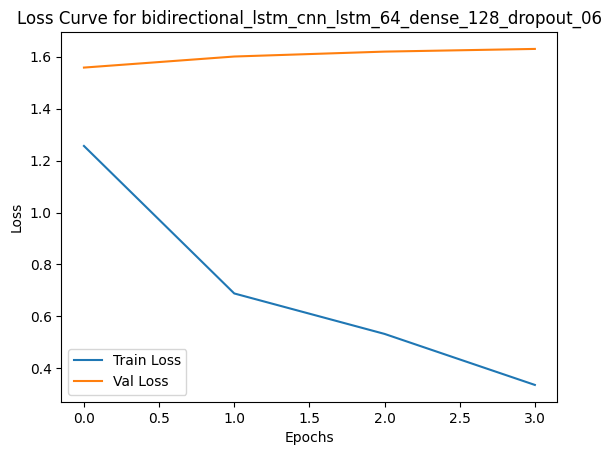

206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
Accuracy: 0.552463503649635
F1 Score (macro): 0.5793649501081102

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.37      0.39       800
           1       0.70      0.80      0.74       232
           2       0.47      0.54      0.50       800
           3       0.69      0.69      0.69       800
           4       0.61      0.56      0.59       800
           5       0.47      0.22      0.30       776
           6       0.84      0.83      0.83       324
           7       0.41      0.78      0.54       616
           8       0.78      0.73      0.75       628
           9       0.49      0.43      0.46       800

    accuracy                           0.55      6576
   macro avg       0.59      0.59      0.58      6576
weighted avg       0.56      0.55      0.54      6576



In [45]:
bidirectional_lstm_cnn_lstm_64_dense_128_dropout_06 = build_and_train_Bidirectional_LSTM_CNN_model(model_name="bidirectional_lstm_cnn_lstm_64_dense_128_dropout_06", lstm_units=64, dense_units=128, dropout_rate=0.6)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_24                  │ (None, 180, 64)             │           3,520 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 178, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 89, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 89, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 70,346 (274.79 KB)

 Trainable params: 70,346 (274.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - accuracy: 0.1565 - loss: 2.2442 - val_accuracy: 0.3977 - val_loss: 1.9674 - learning_rate: 1.0000e-04
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.3122 - loss: 1.9060 - val_accuracy: 0.4331 - val_loss: 1.7324 - learning_rate: 1.0000e-04
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4398 - loss: 1.6082 - val_accuracy: 0.4667 - val_loss: 1.6279 - learning_rate: 1.0000e-04
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.5277 - loss: 1.4140 - val_accuracy: 0.4980 - val_loss: 1.5545 - learning_rate: 1.0000e-04
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.5992 - loss: 1.2394 - val_accuracy: 0.5036 - val_loss: 1.5330 - learning_rate: 1.0000e-04
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.6347 - loss: 1.1626 - val_accuracy: 0.5339 - val_loss: 1.5196 - learning_rate: 1.0000e-04
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 12s 3

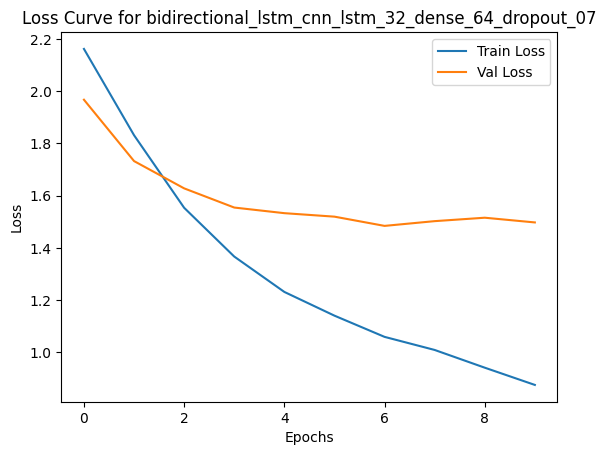

206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
Accuracy: 0.5664537712895377
F1 Score (macro): 0.5804401295739081

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.53      0.54       800
           1       0.60      0.60      0.60       232
           2       0.50      0.53      0.51       800
           3       0.64      0.63      0.63       800
           4       0.65      0.47      0.55       800
           5       0.62      0.44      0.52       776
           6       0.73      0.79      0.76       324
           7       0.45      0.61      0.52       616
           8       0.63      0.69      0.66       628
           9       0.48      0.56      0.52       800

    accuracy                           0.57      6576
   macro avg       0.58      0.59      0.58      6576
weighted avg       0.58      0.57      0.57      6576



In [46]:
bidirectional_lstm_cnn_lstm_32_dense_64_dropout_07_learning_rate_0001 = build_and_train_Bidirectional_LSTM_CNN_model(model_name="bidirectional_lstm_cnn_lstm_32_dense_64_dropout_07", lstm_units=32, dense_units=64, dropout_rate=0.7, learning_rate=0.0001)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_25                  │ (None, 180, 64)             │           3,520 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 178, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 89, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 89, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,538 (775.54 KB)

 Trainable params: 198,538 (775.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - accuracy: 0.2174 - loss: 2.1470 - val_accuracy: 0.4028 - val_loss: 1.7147 - learning_rate: 1.0000e-04
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.4894 - loss: 1.5014 - val_accuracy: 0.4933 - val_loss: 1.5327 - learning_rate: 1.0000e-04
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6476 - loss: 1.1173 - val_accuracy: 0.5450 - val_loss: 1.4985 - learning_rate: 1.0000e-04
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.7305 - loss: 0.8979 - val_accuracy: 0.5528 - val_loss: 1.5184 - learning_rate: 1.0000e-04
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.7589 - loss: 0.7915 - val_accuracy: 0.5640 - val_loss: 1.5157 - learning_rate: 1.0000e-04
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.7976 - loss: 0.6824 - val_accuracy: 0.5704 - val_loss: 1.5331 - learning_rate: 1.0000e-05


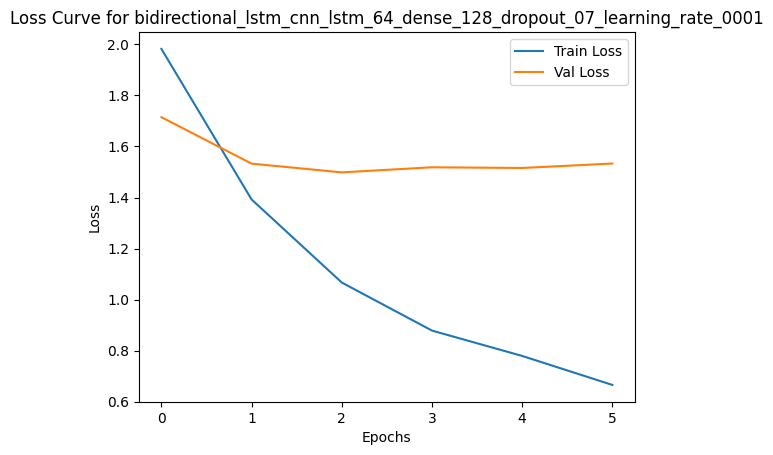

206/206 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step
Accuracy: 0.5450121654501217
F1 Score (macro): 0.5619542787285015

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.27      0.35       800
           1       0.64      0.66      0.65       232
           2       0.50      0.50      0.50       800
           3       0.64      0.71      0.67       800
           4       0.65      0.50      0.56       800
           5       0.43      0.34      0.38       776
           6       0.80      0.73      0.76       324
           7       0.47      0.59      0.52       616
           8       0.67      0.77      0.72       628
           9       0.43      0.63      0.51       800

    accuracy                           0.55      6576
   macro avg       0.57      0.57      0.56      6576
weighted avg       0.55      0.55      0.54      6576



In [47]:
bidirectional_lstm_cnn_lstm_64_dense_128_dropout_07_learning_rate_0001 = build_and_train_Bidirectional_LSTM_CNN_model(model_name="bidirectional_lstm_cnn_lstm_64_dense_128_dropout_07_learning_rate_0001", lstm_units=64, dense_units=128, dropout_rate=0.7, learning_rate=0.0001)

In [48]:
best_model = bidirectional_lstm_cnn_lstm_32_dense_64_dropout_07_learning_rate_0001[0]

In [49]:
evaluate_model(best_model, X_val, y_val)

206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
Accuracy: 0.5664537712895377
F1 Score (macro): 0.5804401295739081

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.53      0.54       800
           1       0.60      0.60      0.60       232
           2       0.50      0.53      0.51       800
           3       0.64      0.63      0.63       800
           4       0.65      0.47      0.55       800
           5       0.62      0.44      0.52       776
           6       0.73      0.79      0.76       324
           7       0.45      0.61      0.52       616
           8       0.63      0.69      0.66       628
           9       0.48      0.56      0.52       800

    accuracy                           0.57      6576
   macro avg       0.58      0.59      0.58      6576
weighted avg       0.58      0.57      0.57      6576



(0.5664537712895377, 0.5804401295739081)

206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


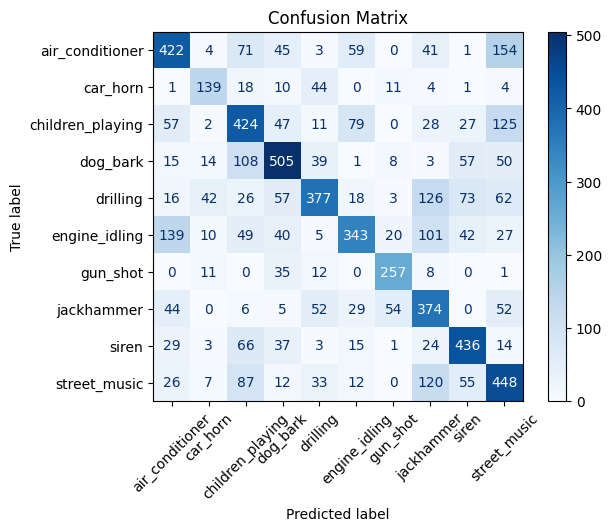

In [52]:
confusion_matrix = plot_conf_matrix(best_model, X_val, y_val)

In [ ]:
proj_16_model = PROJ_16[0]